## **Specialized Components for Optimized News Summarization**

In [1]:
import requests
from typing import List
from haystack.components.fetchers import LinkContentFetcher
from haystack.components.converters import HTMLToDocument
from haystack import Document, Pipeline, component
from haystack.components.builders import PromptBuilder
from haystack.components.generators.openai import OpenAIGenerator

In [2]:
import warnings
from helper import load_env

warnings.filterwarnings('ignore')
load_env()

## Modified Component Needs

#### Constructing a suitable component and execute it

In [4]:
@component
class Greeter:

    @component.output_types(greeting=str)
    def run(self, user_name: str):
        return {"greeting": f"Hello {user_name}"}
    
greeter = Greeter()
greeter.run(user_name="Tuana")


{'greeting': 'Hello Tuana'}

#### Adding the Component to a Pipeline

In [ ]:
greeter = Greeter()
template = """ You will be given the beginning of a dialogue. 
Create a short play script using this as the start of the play.
Start of dialogue: {{ dialogue }}
Full script: 
"""
prompt = PromptBuilder(template=template)
llm = OpenAIGenerator()

dialogue_builder = Pipeline()
dialogue_builder.add_component("greeter", greeter)
dialogue_builder.add_component("prompt", prompt)
dialogue_builder.add_component("llm", llm)

dialogue_builder.connect("greeter.greeting", "prompt.dialogue")
dialogue_builder.connect("prompt", "llm")

In [ ]:
dialogue_builder.show()

In [ ]:
dialogue = dialogue_builder.run({"greeter": {"user_name": "Tuana"}})

print(dialogue["llm"]["replies"][0])

## Now making a Hacker Based News Summarizer as a part of mini project.

In [7]:
trending_list = requests.get(url="https://hacker-news.firebaseio.com/v0/topstories.json?print=pretty")
post = requests.get(url=f"https://hacker-news.firebaseio.com/v0/item/{trending_list.json()[0]}.json?print=pretty")
print(post.json())

{'by': 'louwrentius', 'descendants': 196, 'id': 41536088, 'kids': [41536897, 41538213, 41537401, 41536279, 41537789, 41536664, 41536716, 41536293, 41536120, 41538691, 41537920, 41536432, 41538014, 41537312, 41538029, 41536955, 41536603, 41537602, 41537291, 41536531, 41537500, 41536213, 41536702, 41538643, 41536695, 41537717, 41536217, 41536426, 41536768, 41536389, 41536750, 41536739, 41537894, 41536569, 41536477, 41536200, 41537366, 41537275, 41536771, 41538122, 41538123, 41538124, 41537148], 'score': 267, 'time': 1726269670, 'title': 'My 71 TiB ZFS NAS After 10 Years and Zero Drive Failures', 'type': 'story', 'url': 'https://louwrentius.com/my-71-tib-zfs-nas-after-10-years-and-zero-drive-failures.html'}


In [8]:
@component
class HackernewsNewestFetcher:
    @component.output_types(articles=List[Document])
    def run(self, top_k: int):
        articles = []
        return {"articles": articles}

In [9]:
@component
class HackernewsNewestFetcher:
    def __init__(self):
        fetcher = LinkContentFetcher()
        converter = HTMLToDocument()

        html_conversion_pipeline = Pipeline()
        html_conversion_pipeline.add_component("fetcher", fetcher)
        html_conversion_pipeline.add_component("converter", converter)

        html_conversion_pipeline.connect("fetcher", "converter")
        self.html_pipeline = html_conversion_pipeline
        
    @component.output_types(articles=List[Document])
    def run(self, top_k: int):
        articles = []
        trending_list = requests.get(
            url="https://hacker-news.firebaseio.com/v0/topstories.json?print=pretty"
        )
        for id in trending_list.json()[0:top_k]:
            post = requests.get(
                url=f"https://hacker-news.firebaseio.com/v0/item/{id}.json?print=pretty"
            )
            if "url" in post.json():
                try:
                    article = self.html_pipeline.run(
                        {"fetcher": {"urls": [post.json()["url"]]}}
                    )
                    articles.append(article["converter"]["documents"][0])
                except:
                    print(f"Can't download {post}, skipped")
            elif "text" in post.json():
                try:
                    articles.append(Document(content=post.json()["text"], meta= {"title": post.json()["title"]}))
                except:
                    print(f"Can't download {post}, skipped")
        return {"articles": articles}

In [10]:
fetcher = HackernewsNewestFetcher()
results = fetcher.run(top_k=3)

print(results['articles'])

[Document(id=50049a3667bbba8df689d717af953a67ac60fe1487d6be2ec4d5c0b358af2be9, content: 'My 4U 71 TiB ZFS NAS built with twenty-four 4 TB drives is over 10 years old and still going strong....', meta: {'content_type': 'text/html', 'url': 'https://louwrentius.com/my-71-tib-zfs-nas-after-10-years-and-zero-drive-failures.html'}), Document(id=e25bce4ed98011809db91b5d8cc9c2f06dab24b57964a36d064dd5c61439bd50, content: 'A simple, lexically scoped Lisp interpreter that operates fully in Rust's declarative macros. The li...', meta: {'content_type': 'text/html', 'url': 'https://github.com/RyanWelly/lisp-in-rs-macros'}), Document(id=4c573656bc1401544c006477b293806ad2c06cb84766ff0cb28e92c72eff17b3, content: '"You should go and check out the shell script in the repo because it's very nice. It has colored out...', meta: {'content_type': 'text/html', 'url': 'https://nochlin.com/blog/6-techniques-i-use-to-create-a-great-user-experience-for-shell-scripts'})]


In [11]:
prompt_template = """  
You will be provided a few of the top posts in HackerNews.  
For each post, provide a brief summary if possible.
  
Posts:  
{% for article in articles %}
  Post:\n
  {{ article.content}}
{% endfor %}  
"""

In [12]:
prompt_builder = PromptBuilder(template=prompt_template)
fetcher = HackernewsNewestFetcher()
llm = OpenAIGenerator()

summarizer_pipeline = Pipeline()
summarizer_pipeline.add_component("fetcher", fetcher)
summarizer_pipeline.add_component("prompt", prompt_builder)
summarizer_pipeline.add_component("llm", llm)

summarizer_pipeline.connect("fetcher.articles", "prompt.articles")
summarizer_pipeline.connect("prompt", "llm")

🚅 Components
  - fetcher: HackernewsNewestFetcher
  - prompt: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - fetcher.articles -> prompt.articles (List[Document])
  - prompt.prompt -> llm.prompt (str)

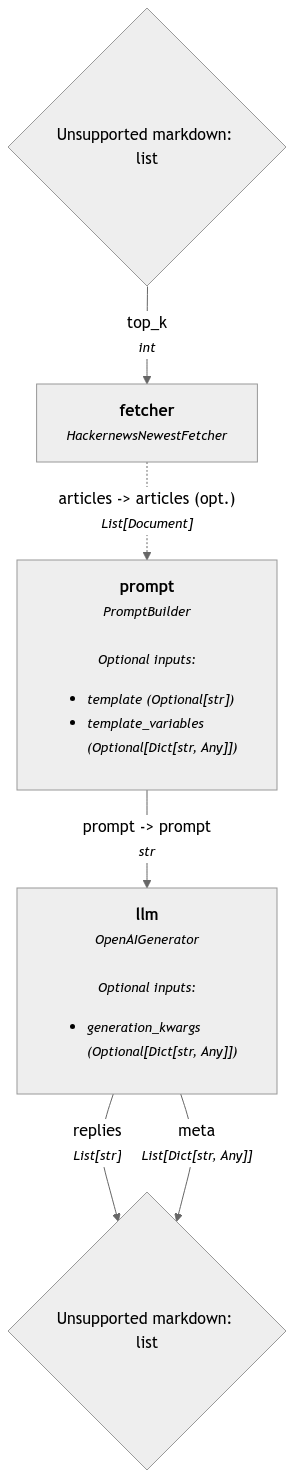

In [13]:
summarizer_pipeline.show()

In [15]:
summaries = summarizer_pipeline.run({"fetcher": {"top_k": 3}})
print(summaries["llm"]["replies"][0])

Post 1 Summary:
The post discusses the longevity and reliability of a ZFS NAS built with twenty-four 4 TB drives that has been operational for over 10 years without any drive failures. The author shares insights on drive longevity, the benefits of turning off the NAS when not in use, the importance of using ZFS, and the strategies employed to keep the system cool and quiet. Additionally, the post touches on topics like data corruption risks, power supply issues, network configurations, and backup strategies. The author also shares future storage plans and acknowledges the potential end of their storage hobby.

Post 2 Summary:
The post highlights a simple Lisp interpreter written using Rust's declarative macros. The interpreter operates fully within Rust's macros, providing compile-time evaluation of Lisp code. The author showcases examples of evaluating Lisp expressions, including a quine, and discusses the limitations of explicit recursion in the current implementation. The post also 

In [16]:
prompt_template = """  
You will be provided a few of the top posts in HackerNews, followed by their URL.  
For each post, provide a brief summary followed by the URL the full post can be found at.  
  
Posts:  
{% for article in articles %}  
  {{ article.content }}
  URL: {{ article.meta["url"] }}
{% endfor %}  
"""

prompt_builder = PromptBuilder(template=prompt_template)
fetcher = HackernewsNewestFetcher()
llm = OpenAIGenerator()

summarizer_pipeline = Pipeline()
summarizer_pipeline.add_component("fetcher", fetcher)
summarizer_pipeline.add_component("prompt", prompt_builder)
summarizer_pipeline.add_component("llm", llm)

summarizer_pipeline.connect("fetcher.articles", "prompt.articles")
summarizer_pipeline.connect("prompt", "llm")

🚅 Components
  - fetcher: HackernewsNewestFetcher
  - prompt: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - fetcher.articles -> prompt.articles (List[Document])
  - prompt.prompt -> llm.prompt (str)

In [21]:
summaries = summarizer_pipeline.run({"fetcher": {"top_k": 6}})
print(summaries["llm"]["replies"][0])

1. My 4U 71 TiB ZFS NAS built with twenty-four 4 TB drives is over 10 years old and still hasn't experienced a single drive failure. The owner shares their secret of drive longevity, energy-saving strategies, ZFS usage, and custom fan control. They also discuss future storage plans and the story behind their NAS build.  
URL: https://louwrentius.com/my-71-tib-zfs-nas-after-10-years-and-zero-drive-failures.html

2. A Lisp interpreter written fully in Rust's declarative macros, operating at compile time by rustc expanding macros. The post highlights the simplicity of the interpreter, providing code examples and a quine. It references resources for further learning about Lisp and functional programming.  
URL: https://github.com/RyanWelly/lisp-in-rs-macros

3. Techniques for creating a great user experience for shell scripts are discussed, focusing on clear error handling, colorful output, detailed progress reporting, strategic error handling, platform-specific adaptations, and timestampe

In [22]:
fetcher = HackernewsNewestFetcher()
results = fetcher.run(top_k=3)

print(results['articles'])

[Document(id=50049a3667bbba8df689d717af953a67ac60fe1487d6be2ec4d5c0b358af2be9, content: 'My 4U 71 TiB ZFS NAS built with twenty-four 4 TB drives is over 10 years old and still going strong....', meta: {'content_type': 'text/html', 'url': 'https://louwrentius.com/my-71-tib-zfs-nas-after-10-years-and-zero-drive-failures.html'}), Document(id=e25bce4ed98011809db91b5d8cc9c2f06dab24b57964a36d064dd5c61439bd50, content: 'A simple, lexically scoped Lisp interpreter that operates fully in Rust's declarative macros. The li...', meta: {'content_type': 'text/html', 'url': 'https://github.com/RyanWelly/lisp-in-rs-macros'}), Document(id=4c573656bc1401544c006477b293806ad2c06cb84766ff0cb28e92c72eff17b3, content: '"You should go and check out the shell script in the repo because it's very nice. It has colored out...', meta: {'content_type': 'text/html', 'url': 'https://nochlin.com/blog/6-techniques-i-use-to-create-a-great-user-experience-for-shell-scripts'})]
